# Multi-Class Image Classification Model for Shoes Footwear Types Using TensorFlow Take 2
### David Lowe
### December 5, 2022

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Shoes Footwear Types Dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset contains over 13,000 images of shoes in five classes. The training set contains 2,000 training images assigned to each class. The validation set contains 500 validation images assigned to each class. The test set has a random number of images assigned to each class.

ANALYSIS: The ResNet50V2 model's performance achieved an accuracy score of 80.84% after five epochs using the validation dataset. When we applied the model to the test dataset, the model achieved an accuracy score of 83.13%.

CONCLUSION: In this iteration, the TensorFlow ResNet50V2 CNN model appeared suitable for modeling this dataset.

Dataset ML Model: Multi-Class classification with numerical features

Dataset Used: Shoes Classification Dataset

Dataset Reference: https://www.kaggle.com/datasets/utkarshsaxenadn/shoes-classification-dataset-13k-images

One source of potential performance benchmarks: https://www.kaggle.com/datasets/utkarshsaxenadn/shoes-classification-dataset-13k-images/code

# Task 1 - Prepare Environment

In [1]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [2]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sat Dec  3 00:26:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [7]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 3
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 5
BATCH_SIZE = 32
# CLASS_LABELS = []
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (250, 250)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/Shoes Dataset/Train'
VALID_DIR = 'staging/Shoes Dataset/Valid'
TEST_DIR = 'staging/Shoes Dataset/Test'
TRAIN_DATASET = 'archive.zip'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.9.2


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [10]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/

if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-utkarshsaxenadn-shoes-classification/archive.zip

zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

--2022-12-03 00:26:57--  https://dainesanalytics.com/datasets/kaggle-utkarshsaxenadn-shoes-classification/archive.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 99.84.160.56, 99.84.160.88, 99.84.160.109, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|99.84.160.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289031370 (276M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>] 275.64M   101MB/s    in 2.7s    

2022-12-03 00:27:00 (101 MB/s) - ‘archive.zip’ saved [289031370/289031370]



In [12]:
CLASS_LABELS = os.listdir(TRAIN_DIR)
print(CLASS_LABELS)
NUM_CLASSES = len(CLASS_LABELS)
print('Total number of classes detected:', NUM_CLASSES)

['Clog', 'Sneaker', 'Brogue', 'Boat', 'Ballet Flat']
Total number of classes detected: 5


In [13]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5],'\n')

Number of training images for Clog : 2000
Training samples for Clog : ['Clog-Train (214).jpeg', 'Clog-Train (217).jpeg', 'Clog-Train (1204).jpeg', 'Clog-Train (860).jpeg', 'Clog-Train (546).jpeg'] 

Number of training images for Sneaker : 2000
Training samples for Sneaker : ['Sneaker-Train (1295).jpeg', 'Sneaker-Train (600).jpeg', 'Sneaker-Train (864).jpeg', 'Sneaker-Train (1909).jpeg', 'Sneaker-Train (685).jpeg'] 

Number of training images for Brogue : 2000
Training samples for Brogue : ['Brogue Shoe-Train (1828).jpeg', 'Brogue Shoe-Train (1703).jpeg', 'Brogue Shoe-Train (705).jpeg', 'Brogue Shoe-Train (1681).jpeg', 'Brogue Shoe-Train (581).jpeg'] 

Number of training images for Boat : 2000
Training samples for Boat : ['Boat Shoe-Train (1513).jpeg', 'Boat Shoe-Train (1228).jpeg', 'Boat Shoe-Train (1141).jpeg', 'Boat Shoe-Train (64).jpeg', 'Boat Shoe-Train (391).jpeg'] 

Number of training images for Ballet Flat : 2000
Training samples for Ballet Flat : ['Ballet Flat-Train (1431).jpeg

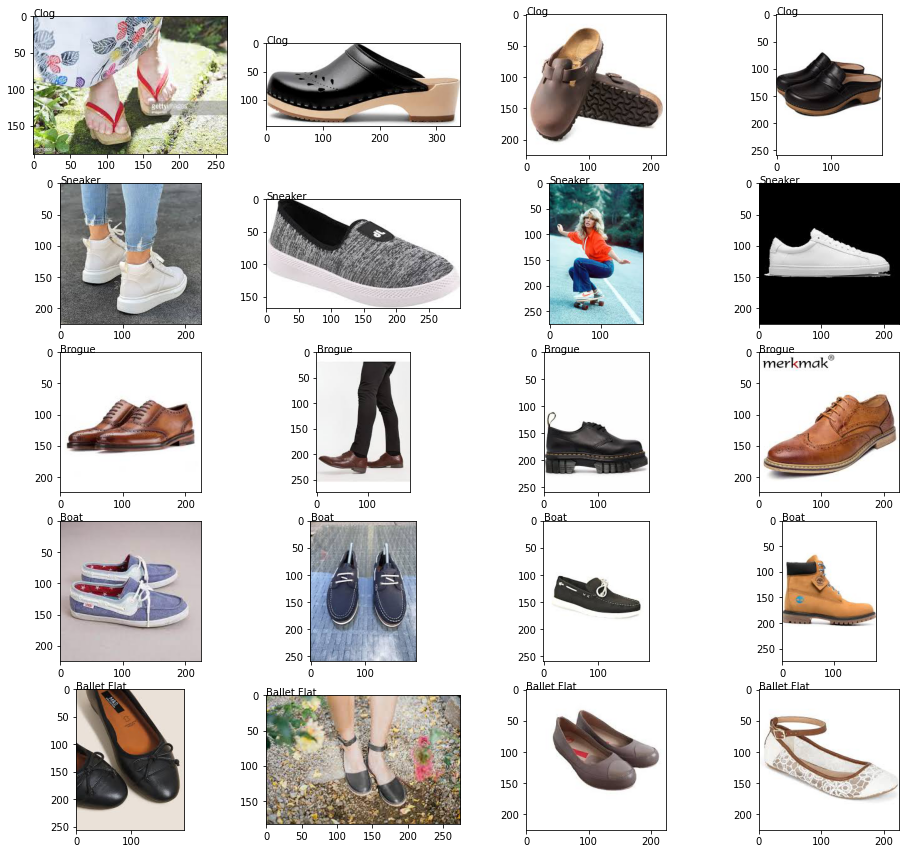

In [14]:
# Plot some training images from the dataset
nrows = len(CLASS_LABELS)
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [15]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=45,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=VALID_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 10000 images belonging to 5 classes.
Number of training image batches per epoch of modeling: 313
Loading and pre-processing the validation images...
Found 2500 images belonging to 5 classes.
Number of validation image batches per epoch of modeling: 79


In [16]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [17]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [18]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [19]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu')),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [20]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/5
313/313 [==============================] - 126s 355ms/step - loss: 1.0679 - accuracy: 0.6766 - val_loss: 0.6650 - val_accuracy: 0.7632
Epoch 2/5
313/313 [==============================] - 110s 351ms/step - loss: 0.5912 - accuracy: 0.7936 - val_loss: 0.5864 - val_accuracy: 0.8020
Epoch 3/5
313/313 [==============================] - 110s 351ms/step - loss: 0.4840 - accuracy: 0.8356 - val_loss: 0.5519 - val_accuracy: 0.8172
Epoch 4/5
313/313 [==============================] - 110s 350ms/step - loss: 0.4271 - accuracy: 0.8578 - val_loss: 0.6333 - val_accuracy: 0.7872
Epoch 5/5
313/313 [==============================] - 111s 353ms/step - loss: 0.3937 - accuracy: 0.8676 - val_loss: 0.6005 - val_accuracy: 0.8084
Total time for model fitting: 0:09:32.448686


In [21]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 2048)              205522944 
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 229,097,989
Trainable params: 229,052,549
Non-trainable params: 45,440
_________________________________________________________________


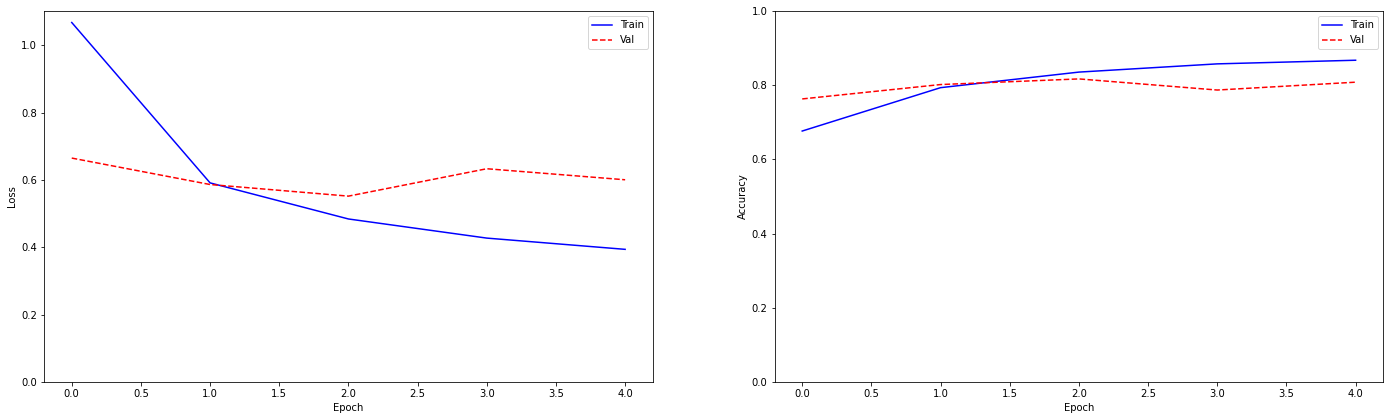

In [22]:
plot_metrics(baseline_model_history)

In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [24]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Not applicable for this iteration of modeling

In [26]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [27]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [28]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(training_generator, epochs=MAX_EPOCHS, verbose=0)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 2048)              205522944 
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 229,097,989
Trainable params: 229,052,549
Non-trainable params: 45,440
_________________________________________________________________


In [30]:
print('Loading and pre-processing the test images...')
test_generator = validation_datagen.flow_from_directory(directory=TEST_DIR,
                                                        target_size=TARGET_IMAGE_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False,
                                                        **dataflow_kwargs)
print('Number of test image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the test images...
Found 1215 images belonging to 5 classes.
Number of test image batches per epoch of modeling: 38


In [31]:
# Print the labels used for the modeling
print(test_generator.class_indices)

{'Ballet Flat': 0, 'Boat': 1, 'Brogue': 2, 'Clog': 3, 'Sneaker': 4}


In [32]:
final_model.evaluate(test_generator, verbose=1)

38/38 [==============================] - 3s 61ms/step - loss: 0.6431 - accuracy: 0.8313


[0.643116295337677, 0.8312757015228271]

In [33]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [34]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:19:10.382029
